In [1]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs, \
compute_log_likelihood_by_week, get_positives_by_week_from_traj

path = "fall_2021_prior_samples:1633381945"
files = [f for f in listdir(path) if isfile(join(path, f)) and 'with_trajectories' in f ]



In [97]:
path2 = "fall_2021_prior_samples:1633456006"
files2 = [f for f in listdir(path2) if isfile(join(path2, f)) and 'with_trajectories' in f ]

In [100]:

count = 0
for f in files2:
    with open(join(path2, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 10 == 0:
        print("Loaded {} points".format(count))
        #break
    
        
        

Loaded 10 points
Loaded 20 points
Loaded 30 points
Loaded 40 points
Loaded 50 points
Loaded 60 points
Loaded 70 points
Loaded 80 points
Loaded 90 points
Loaded 100 points
Loaded 110 points
Loaded 120 points
Loaded 130 points
Loaded 140 points
Loaded 150 points
Loaded 160 points
Loaded 170 points
Loaded 180 points
Loaded 190 points
Loaded 200 points
Loaded 210 points
Loaded 220 points
Loaded 230 points
Loaded 240 points
Loaded 250 points
Loaded 260 points
Loaded 270 points
Loaded 280 points
Loaded 290 points
Loaded 300 points
Loaded 310 points
Loaded 320 points
Loaded 330 points
Loaded 340 points
Loaded 350 points
Loaded 360 points
Loaded 370 points
Loaded 380 points
Loaded 390 points
Loaded 400 points
Loaded 410 points
Loaded 420 points
Loaded 430 points
Loaded 440 points
Loaded 450 points
Loaded 460 points
Loaded 470 points
Loaded 480 points
Loaded 490 points
Loaded 500 points
Loaded 510 points
Loaded 520 points
Loaded 530 points
Loaded 540 points
Loaded 550 points
Loaded 560 points
L

KeyboardInterrupt: 

In [30]:
sampled_points = {}
aggregated_trajs = {}

count = 0
for f in files:
    with open(join(path, f), "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs(inf_trajs_by_group)
    count += 1
    if count % 10 == 0:
        print("Loaded {} points".format(count))
        #break
    
        
        

Loaded 10 points
Loaded 20 points
Loaded 30 points
Loaded 40 points
Loaded 50 points
Loaded 60 points
Loaded 70 points
Loaded 80 points
Loaded 90 points
Loaded 100 points
Loaded 110 points
Loaded 120 points
Loaded 130 points
Loaded 140 points
Loaded 150 points
Loaded 160 points
Loaded 170 points
Loaded 180 points
Loaded 190 points
Loaded 200 points
Loaded 210 points
Loaded 220 points
Loaded 230 points
Loaded 240 points
Loaded 250 points
Loaded 260 points
Loaded 270 points
Loaded 280 points
Loaded 290 points
Loaded 300 points
Loaded 310 points
Loaded 320 points
Loaded 330 points
Loaded 340 points
Loaded 350 points
Loaded 360 points
Loaded 370 points
Loaded 380 points
Loaded 390 points
Loaded 400 points
Loaded 410 points
Loaded 420 points
Loaded 430 points
Loaded 440 points
Loaded 450 points
Loaded 460 points
Loaded 470 points
Loaded 480 points
Loaded 490 points
Loaded 500 points
Loaded 510 points
Loaded 520 points
Loaded 530 points
Loaded 540 points
Loaded 550 points
Loaded 560 points
L

In [101]:
len(sampled_points)

2978

In [102]:
import numpy as np

def convert_cum_traj_to_daily_count(traj):
    prev_cum_cases = 0
    daily_count = []
    for current_cum_cases in traj:
        daily_count.append(current_cum_cases - prev_cum_cases)
        prev_cum_cases = current_cum_cases
    return daily_count

def convert_daily_count_traj_to_weekly_count(daily_count_traj):
    weekly_count = []
    lower_idx = 0
    upper_idx = 7 
    while lower_idx <= len(daily_count_traj):
        weekly_count.append(sum(daily_count_traj[lower_idx:upper_idx]))
        lower_idx = upper_idx
        upper_idx += 7
    assert(np.abs(sum(weekly_count) - sum(daily_count_traj)) < 1e-5)
    return weekly_count

def get_weekly_counts(cum_traj):
    daily_count = convert_cum_traj_to_daily_count(cum_traj)
    return convert_daily_count_traj_to_weekly_count(daily_count)


    

In [103]:
from scipy.stats import norm

ACTUAL_TRAJ = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1]#,0,0]

def compute_lognormal_loglik(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx] + 1e-10))
            #log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx]))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    # compute log likelihood for observed data
    loglik = 0
    for week_idx, actual_positives in enumerate(actual_weekly_traj):
        log_positives = np.log(actual_positives)
        #scaled_log_positives = (log_positives - means_by_week[week_idx]) / stddevs_by_week[week_idx]
        #print(log_positives, means_by_week[week_idx], stddevs_by_week[week_idx], scaled_log_positives)
        loglik += norm.logpdf(log_positives, loc=means_by_week[week_idx], 
                                  scale=stddevs_by_week[week_idx])
    
    return loglik

#compute_lognormal_loglik(aggregated_trajs[f])

In [104]:
import numpy as np
logliks = {}
for f in sampled_points:
    logliks[f] = compute_lognormal_loglik(aggregated_trajs[f])
    #print("\n\n\n")

KeyError: 'point_2977_with_trajectories.dill'

In [107]:
del sampled_points['point_2977_with_trajectories.dill']

In [108]:
from fall_2021_projection_utils import UNCERTAINTY_PARAMS

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx])
        param_logliks[param].append(logliks[f])
    

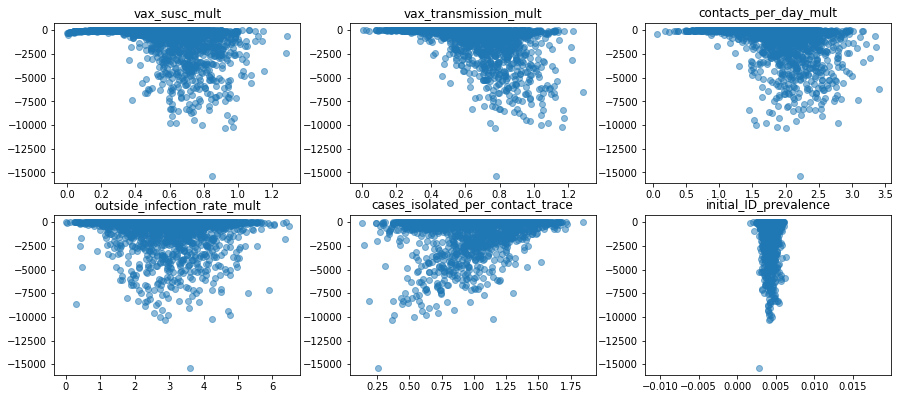

In [109]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    min_val = min([x for x in param_logliks[param] if x != float('-inf')])

    plt.subplot(3,3,idx+1)
    plt.scatter(param_vals[param], 
                [x if x != float('-inf') else min_val for x in param_logliks[param]],
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

In [110]:
import pandas as pd
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
df.shape

(2977, 8)

In [125]:
df.shape

(2977, 10)

In [111]:
likelihoods = [np.exp(loglik) for loglik in param_logliks[UNCERTAINTY_PARAMS[0]]]
df['likelihood'] = likelihoods

In [112]:
normalizer = df['likelihood'].sum()
df['posterior'] = df['likelihood'] / normalizer

In [134]:
import time
time.strftime("%y_%m_%d_%H:%M_posteriors.csv", time.localtime())


'21_10_06_13:24_posteriors.csv'

In [136]:
logliks['point_53_with_trajectories.dill']

-55.50772131684638

In [137]:
import time
csv_name = time.strftime("posterior_csvs/%y_%m_%d_%H:%M_posteriors.csv", time.localtime())
df.to_csv(csv_name)

In [138]:
csv_name

'posterior_csvs/21_10_06_13:34_posteriors.csv'

In [113]:
sorted_df = df.dropna().sort_values(by='posterior', ascending=False)

In [114]:
num_points = list(range(df.shape[0]))
posterior_mass = []

for n in num_points:
    subdf = sorted_df.head(n=n)
    posterior_mass.append(subdf['posterior'].sum())
    

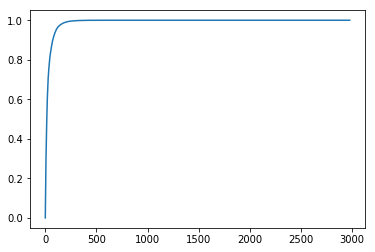

In [115]:
plt.plot(num_points, posterior_mass)

In [118]:
posterior_mass[199]

0.9902519499990392

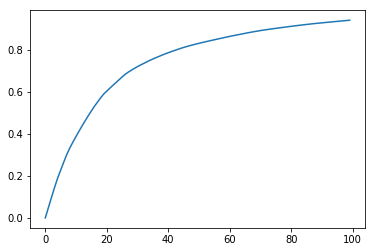

In [119]:
plt.plot(num_points[0:100], posterior_mass[0:100])

Text(0.5,1,'distribution of log-normal log-likelihoods')

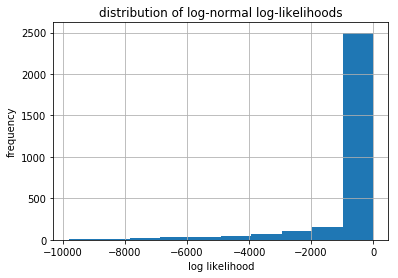

In [121]:
subdf = df[df['log_likelihood'] > -10000]
subdf['log_likelihood'].hist()
plt.xlabel('log likelihood')
plt.ylabel('frequency')
plt.title('distribution of log-normal log-likelihoods')

Text(0.5,1,'distribution of log-normal log-likelihoods')

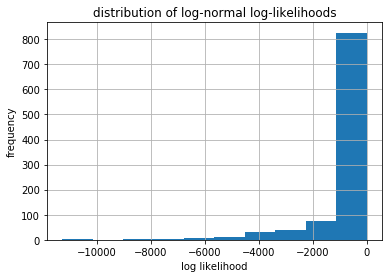

In [71]:
df['log_likelihood'].hist()
plt.xlabel('log likelihood')
plt.ylabel('frequency')
plt.title('distribution of log-normal log-likelihoods')

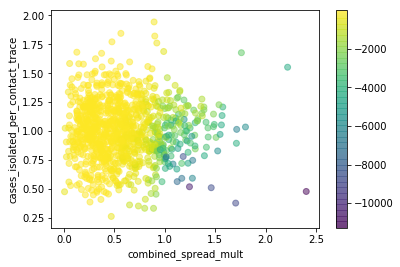

In [72]:
plt.scatter(df['combined_spread_mult'], df['cases_isolated_per_contact_trace'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

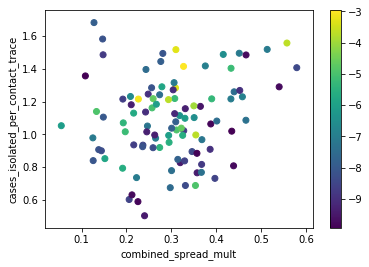

In [73]:
subdf = df[df['log_likelihood'] >= -10]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

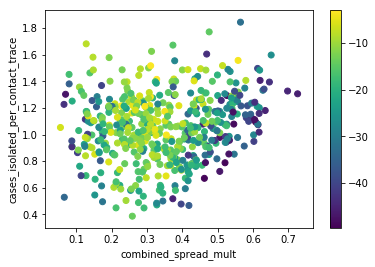

In [74]:
subdf = df[df['log_likelihood'] >= -50]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

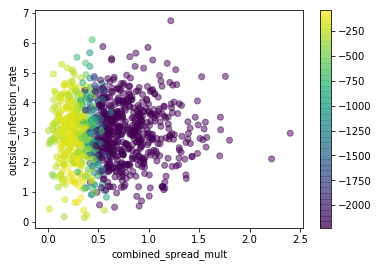

In [34]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()
plt.show()



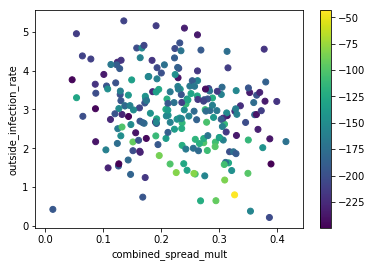

In [35]:
plt.scatter(subdf['combined_spread_mult'], subdf['outside_infection_rate_mult'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()

In [62]:
df[df['log_likelihood'].isnull()]

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult
183,0.170952,0.622440,1.508900,0.170730,0.747789,0.003670,NaN,0.160558
303,0.459748,0.386381,2.028604,0.138056,0.892864,0.005461,NaN,0.360357
753,0.510952,0.014979,1.790451,0.426450,1.221599,0.004690,NaN,0.013703
756,0.422205,0.496458,1.847573,0.217836,1.022912,0.004458,NaN,0.387264


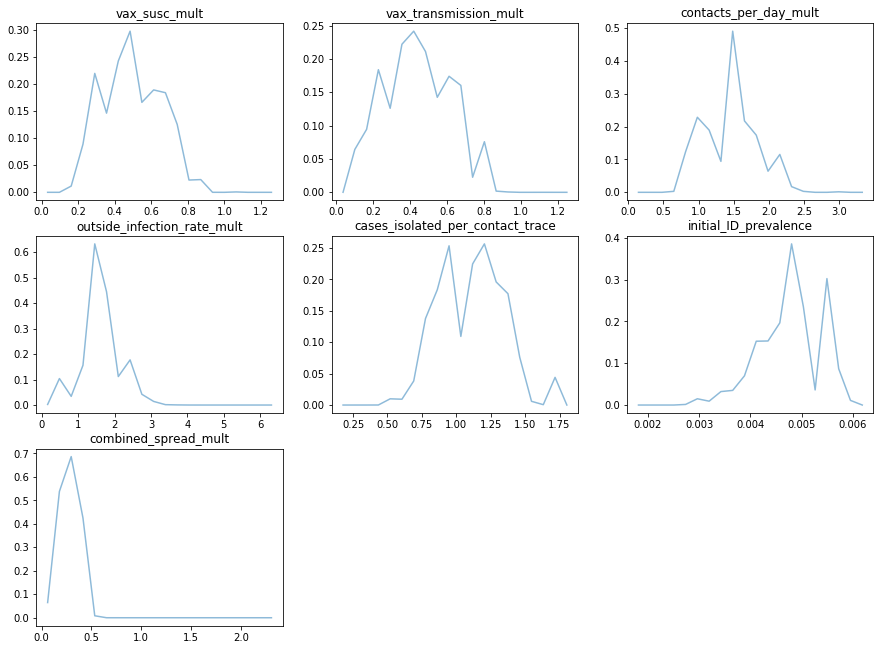

In [124]:
def estimate_marginal_dist(df, param, num_buckets=10):
    bin_boundaries = np.linspace(min(df[param]), max(df[param]), num=num_buckets+1)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        subdf = df[(df[param] >= bin_start_val) & (df[param] < bin_end_val)]
        
        cum_likelihood = 0
        for loglik in subdf['log_likelihood']:
            if np.isnan(loglik):
                continue
            cum_likelihood += np.exp(loglik)
            if np.isnan(np.exp(loglik)):
                print(loglik)
        
        bin_likelihoods.append(cum_likelihood)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,15))
num_buckets=20
for idx, param in enumerate(UNCERTAINTY_PARAMS + ['combined_spread_mult']):

    plt.subplot(4,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(df, param, num_buckets=num_buckets)
    #print(param, likelihoods)
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

In [ ]:
def estimate_marginal_dist(df, param, num_buckets=10):
    bin_boundaries = np.linspace(min(df[param]), max(df[param]), num=num_buckets+1)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        subdf = df[(df[param] >= bin_start_val) & (df[param] < bin_end_val)]
        
        cum_likelihood = 0
        for loglik in subdf['log_likelihood']:
            if np.isnan(loglik):
                continue
            cum_likelihood += np.exp(loglik)
            if np.isnan(np.exp(loglik)):
                print(loglik)
        
        bin_likelihoods.append(cum_likelihood)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS[:-2] + ['combined_spread_mult']):

    plt.subplot(3,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(df, param)
    print(param, likelihoods)
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

# Two-Days-Later Investigation to find the trajectories associated with our 106 points, as well as the size of the dataset against which our 106 points were obtained

In [139]:
df.shape

(2977, 10)

# size of the dataset = 2977. that wasn't so bad

In [140]:
df.head()

,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
0,0.536907,0.796549,1.505754,3.197843,1.194228,0.004279,-55.507721,0.643970,7.821732e-25,4.539063e-25
1,0.535474,0.649085,2.166687,4.640944,0.951367,0.003722,-253.572932,0.753072,7.493333e-111,4.348488e-111
2,0.358574,0.615210,1.625561,3.660296,0.484710,0.004324,-28.378572,0.358596,4.735247e-13,2.747932e-13
3,0.420128,0.760578,2.038492,4.227712,1.176410,0.002850,-82.049963,0.651380,2.323560e-36,1.348395e-36
4,0.646253,0.682923,1.962768,3.571786,1.156498,0.004724,-416.983907,0.866249,8.057314e-182,4.675775e-182


In [141]:
from launch_fall_2021_posterior_sims_whale import load_posterior_df
best_points_df = load_posterior_df()
best_points_df.head()

,Unnamed: 0,vax_susc_mult,vax_transmission_mult,contacts_per_day_mult,outside_infection_rate_mult,cases_isolated_per_contact_trace,initial_ID_prevalence,log_likelihood,combined_spread_mult,likelihood,posterior
2346,2346,0.494898,0.643708,1.165605,1.500197,1.175453,0.005546,-2.478925,0.371326,0.083833,0.048650
2808,2808,0.195144,0.393487,2.178645,1.919851,0.816917,0.005811,-2.485864,0.167291,0.083254,0.048313
71,71,0.584703,0.490781,1.051848,1.300272,0.949628,0.004883,-2.504396,0.301839,0.081725,0.047426
1215,1215,0.555763,0.198611,1.517553,1.828590,0.922839,0.004893,-2.560789,0.167508,0.077244,0.044826
2213,2213,0.450848,0.203761,1.457864,1.908646,0.845300,0.005572,-2.713517,0.133927,0.066303,0.038477


In [146]:
best_point_idxs = set(best_points_df['Unnamed: 0'])
len(best_point_idxs)

106

In [178]:
all_point_paths = {}
idx = 0
for f in sampled_points:
    all_point_paths[idx] = join(path2, f)
    idx += 1

In [179]:
len(all_point_paths)

2977

In [180]:
with open('all_point_paths.dill', 'wb') as fhandle:
    dill.dump(all_point_paths, fhandle)

In [148]:
best_point_fs = {}

idx = 0
for f in sampled_points:
    if idx in best_point_idxs:
        best_point_fs[idx] = f
    idx += 1


In [149]:
best_point_fs[5]

'point_71_with_trajectories.dill'

In [162]:
tuple(sampled_points['point_71_with_trajectories.dill'])

(0.5568346733832142,
 0.16309150908141595,
 2.201928782396558,
 2.2223121408632713,
 1.1114158104521341,
 0.0038614730958053557)

In [161]:
tuple(best_points_df[best_points_df['Unnamed: 0'] == 5][UNCERTAINTY_PARAMS].iloc[0])

(0.5568346733832142,
 0.16309150908141595,
 2.2019287823965583,
 2.222312140863272,
 1.111415810452134,
 0.003861473095805356)

In [167]:
for idx in best_point_idxs:
    f = best_point_fs[idx]
    sampled_point = list(sampled_points[f])
    df_point = list(best_points_df[best_points_df['Unnamed: 0'] == idx][UNCERTAINTY_PARAMS].iloc[0])
    assert(np.linalg.norm(np.array(sampled_point) - np.array(df_point)) < 1e-5)

In [169]:
with open('posterior_points.dill', 'wb') as fhandle:
    dill.dump(best_point_fs, fhandle)

In [170]:
posterior_point_paths = {}
for idx, f in best_point_fs.items():
    posterior_point_paths[idx] = join(path2, f)

In [172]:
with open('posterior_point_paths.dill', 'wb') as fhandle:
    dill.dump(posterior_point_paths, fhandle)

In [165]:
sampled_points[best_point_fs[1027]]

[0.45287212186915055,
 0.3461045454411223,
 1.7367577971146109,
 1.5003005560943325,
 1.2106724876459631,
 0.004435764625478047]

In [166]:
best_points_df[best_points_df['Unnamed: 0'] == 1027][UNCERTAINTY_PARAMS].iloc[0]

vax_susc_mult                       0.452872
vax_transmission_mult               0.346105
contacts_per_day_mult               1.736758
outside_infection_rate_mult         1.500301
cases_isolated_per_contact_trace    1.210672
initial_ID_prevalence               0.004436
Name: 1027, dtype: float64

In [173]:
files2

['point_77_with_trajectories.dill',
 'point_13_with_trajectories.dill',
 'point_23_with_trajectories.dill',
 'point_63_with_trajectories.dill',
 'point_12_with_trajectories.dill',
 'point_38_with_trajectories.dill',
 'point_46_with_trajectories.dill',
 'point_22_with_trajectories.dill',
 'point_76_with_trajectories.dill',
 'point_2_with_trajectories.dill',
 'point_6_with_trajectories.dill',
 'point_59_with_trajectories.dill',
 'point_72_with_trajectories.dill',
 'point_41_with_trajectories.dill',
 'point_65_with_trajectories.dill',
 'point_61_with_trajectories.dill',
 'point_36_with_trajectories.dill',
 'point_49_with_trajectories.dill',
 'point_28_with_trajectories.dill',
 'point_7_with_trajectories.dill',
 'point_79_with_trajectories.dill',
 'point_14_with_trajectories.dill',
 'point_26_with_trajectories.dill',
 'point_78_with_trajectories.dill',
 'point_3_with_trajectories.dill',
 'point_17_with_trajectories.dill',
 'point_4_with_trajectories.dill',
 'point_18_with_trajectories.dill

In [175]:
with open('orig_files2_list.dill', 'wb') as fhandle:
    dill.dump(files2, fhandle)